#  Filtrage des ventes immobilières valides

Ce notebook nettoie, prépare et transforme les données DVF pour l'entraînement d'un modèle de prédiction du prix au mètre carré.

##  Importation des bibliothèques

In [21]:
import pandas as pd
import duckdb
import numpy as np



##  Chargement des données
Nous chargeons le jeu de données pré-traité à partir du fichier CSV.

In [22]:
df = pd.read_csv('../data/raw_pre_train_data.csv',index_col=0)
df.shape

(828317, 10)

On constate que le dataset contient 828 317 lignes et 10 colonnes.

##  Vérification des colonnes disponibles

In [23]:
df.columns

Index(['surface_reelle_bati', 'nombre_pieces_principales', 'type_local',
       'code_postal', 'longitude', 'latitude', 'nombre_lots', 'date_mutation',
       'valeur_fonciere', 'id_mutation'],
      dtype='object')

# Feature Engineering 

Calcul du prix du metre carrée pour chaque bien vendu

In [24]:
q ='''
SELECT id_mutation, MAX(valeur_fonciere)/SUM (surface_reelle_bati) AS prix_m2
FROM df
GROUP BY id_mutation
'''
table_m2 = duckdb.query(q).df()

In [25]:
q ='''
SELECT *
FROM df LEFT JOIN table_m2 
USING(id_mutation)

'''
df_w_m2_price = duckdb.query(q).df()
df_w_m2_price.shape

(828317, 11)

Suppression de la colonne valeur_fonciere

In [26]:
df_w_m2_price.drop(['valeur_fonciere'],axis=1,inplace=True)

Filtrage des biens dont le prix au mètre carré est compris entre 1 000 € et 25 000 € afin de se concentrer sur les transactions reflétant la réalité du marché immobilier en Île-de-France.

In [27]:
q ='''
SELECT *
FROM df_w_m2_price
WHERE prix_m2 >= 1000 AND prix_m2 <= 25000 

'''

df_w_m2_price=duckdb.query(q).df()
df_w_m2_price.shape

(796717, 10)

## Création dune variable geo_cluster pour pouvoir exploiter les données geographique de longitude et de latitude

recherche de la valeur optimale du nombre de cluster généré

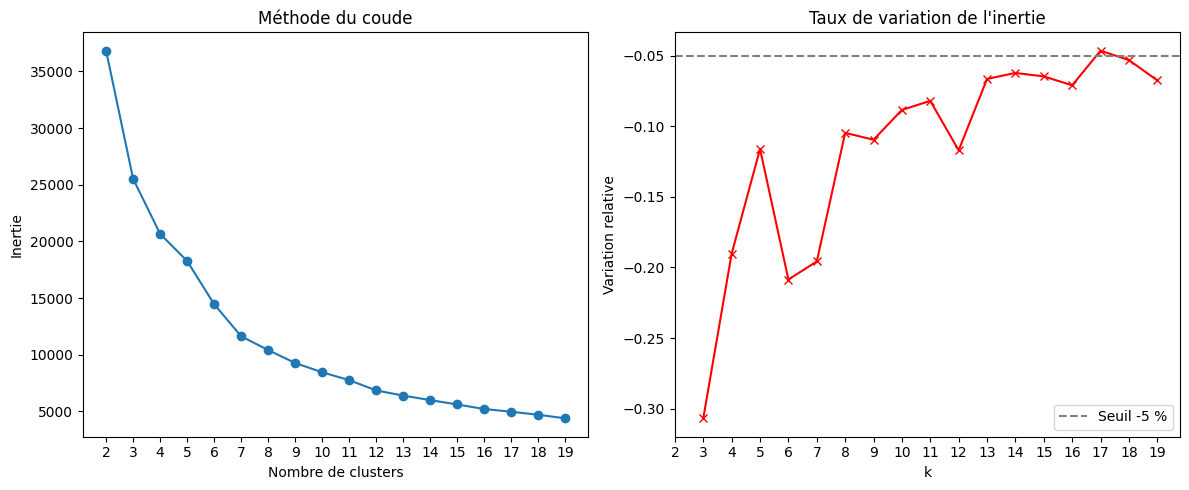

In [29]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df_w_m2_price[['longitude', 'latitude']]  # coordonnées géographiques

inertias = []
k_range = range(2, 20)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

variation = np.diff(inertias) / inertias[:-1]

plt.figure(figsize=(12, 5))

# Coude
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Méthode du coude")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.xticks(k_range) 

# Variation
plt.subplot(1, 2, 2)
plt.plot(k_range[1:], variation, marker='x', color='red')
plt.title("Taux de variation de l'inertie")
plt.xlabel("k")
plt.ylabel("Variation relative")
plt.axhline(y=-0.05, linestyle='--', color='gray', label='Seuil -5 %')
plt.legend()
plt.xticks(k_range)  

plt.tight_layout()
plt.show()


Le graphique de gauche montre l'évolution de l’inertie (somme des distances intra-cluster) en fonction du nombre de clusters.
On observe que l'inertie diminue rapidement jusqu'à k = 16, puis la courbe s’aplatit progressivement :
 cela signifie que l’ajout de clusters au-delà de k = 16 apporte peu de gain supplémentaire.

Le graphique de droite présente la variation relative de l'inertie entre chaque valeur de k.
C’est une façon plus fine de détecter le « point de coude », en identifiant la première valeur de k pour laquelle la diminution devient faible (ici < 5 %).
On observe que la variation passe au-dessus du seuil des −5 % à partir de k = 15, ce qui confirme que :

 k = 16 est la dernière valeur pour laquelle l’ajout d’un cluster apporte un gain significatif en compacité.

In [30]:
kmeans = KMeans(n_clusters=16, random_state=42)
df_w_m2_price['geo_cluster'] = kmeans.fit_predict(X)

## Affichage du clustering

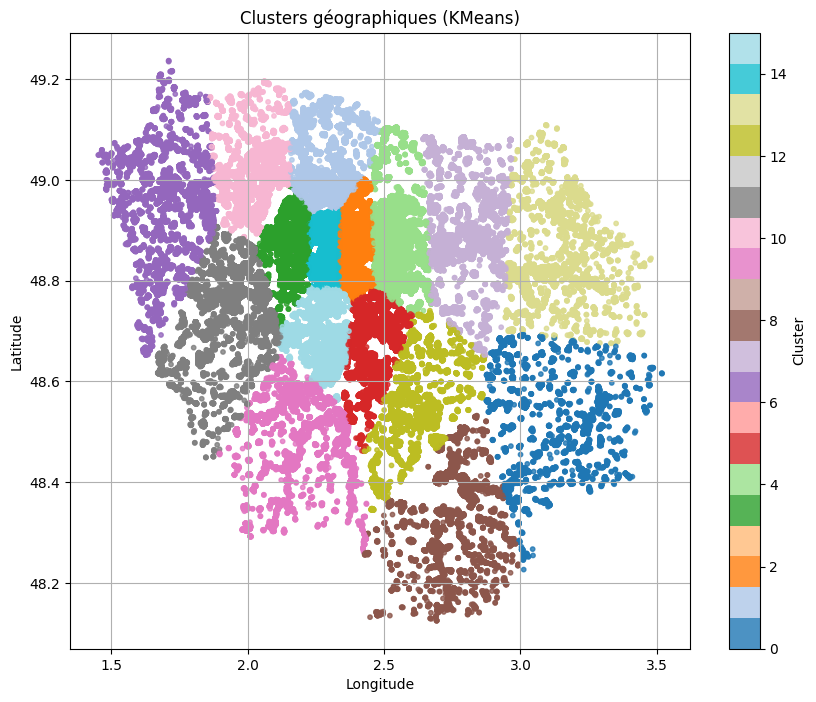

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_w_m2_price['longitude'],
    df_w_m2_price['latitude'],
    c=df_w_m2_price['geo_cluster'],
    cmap='tab20',  
    s=10,
    alpha=0.8
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Clusters géographiques (KMeans)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()

In [32]:
df_w_m2_price.columns

Index(['surface_reelle_bati', 'nombre_pieces_principales', 'type_local',
       'code_postal', 'longitude', 'latitude', 'nombre_lots', 'date_mutation',
       'id_mutation', 'prix_m2', 'geo_cluster'],
      dtype='object')

## Extraction du mois et de l'année

In [33]:
# Assure-toi que 'date_mutation' est bien au format datetime
df_w_m2_price['date_mutation'] = pd.to_datetime(df_w_m2_price['date_mutation'])

# Extraction de l'année et du mois
df_w_m2_price['annee'] = df_w_m2_price['date_mutation'].dt.year
df_w_m2_price['mois'] = df_w_m2_price['date_mutation'].dt.month

In [35]:
df_w_m2_price.drop(columns=['date_mutation'], inplace=True)

# Dataset final

In [45]:
features = [
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'type_local',
    'code_postal',
    'geo_cluster',
    'annee',
    'mois' , 
    'prix_m2'

]
df_cleaned_ready = df_w_m2_price[features]

df_cleaned_ready = df_cleaned_ready.sort_values(by=['annee', 'mois'])

df_cleaned_ready.shape

(796717, 8)

In [46]:
df_cleaned_ready.to_csv('../data/pre_train_data.csv')